In [1]:
#import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

#supress warnings
import warnings
warnings.filterwarnings('ignore')

print("Core libraries are imported successfully!")

Core libraries are imported successfully!


In [2]:
# import PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check PyTorch version
print(f"PyTorch version:{torch.__version__}")

# check for GPU availability
device=torch.device('cuda' if torch.cuda.is_available() else
                    'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using Device:{device}")

# set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
  torch.cuda.manual_seed(42)

print("\n✓ Torch is ready to use!")

PyTorch version:2.9.0+cu126
Using Device:cuda

✓ Torch is ready to use!


In [3]:
# Quick device information
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
elif device.type == 'mps':
    print("Using Apple Metal Performance Shaders (MPS)")
else:
    print("Using CPU - GPU not available")
    print("💡 CPU is fine for learning! All code will work.")

GPU: Tesla T4
CUDA version: 12.6


In [4]:
# Load Fashion - MNIST dataset
from torchvision import datasets, transforms

# Define Transformation: Convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load Training Data
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Download and load Test data
test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

print(f"Training Samples:{len(train_dataset)}")
print(f"Test Samples:{len(test_dataset)}")
print(f"\n✓ Fashion MNIST loaded!")

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 193kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.60MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.2MB/s]

Training Samples:60000
Test Samples:10000

✓ Fashion MNIST loaded!


Dataloader - Batching and shuffling

In [5]:
# Create dataloaders
batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle = True,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

print(f"Number of training batches:{len(train_loader)}")
print(f"Number of test batches:{len(test_loader)}")
print(f"Batch size:{batch_size}")

Number of training batches:938
Number of test batches:157
Batch size:64


# Fashion MNIST classifier

In [6]:
# Define the fashion - MNIST classifier
class FashionMNISTClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1=nn.Linear(28*28, 256)
    self.bn1=nn.BatchNorm1d(256)
    self.dropout1=nn.Dropout(0.3)

    self.fc2=nn.Linear(256, 128)
    self.bn2=nn.BatchNorm1d(128)
    self.dropout2=nn.Dropout(0.3)

    self.fc3=nn.Linear(128, 64)
    self.dropout3=nn.Dropout(0.2)

    self.fc4=nn.Linear(64, 10)

  def forward(self, x):
    # Flatten input
    x=x.view(x.size(0), -1)

    x=self.fc1(x)
    x=self.bn1(x)
    x=F.relu(x)
    x=self.dropout1(x)

    x=self.fc2(x)
    x=self.bn2(x)
    x=F.relu(x)
    x=self.dropout2(x)

    x=F.relu(self.fc3(x))
    x=self.dropout3(x)

    x=F.relu(self.fc4(x))
    return x # No softmax (CrossEntropyLoss includes it)

In [7]:
# create model
fashion_model = FashionMNISTClassifier().to(device)
print(fashion_model)

# Count parameters
total_params = sum(p.numel() for p in fashion_model.parameters())
print(f"Total Parameters:{total_params:,}")

FashionMNISTClassifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)
Total Parameters:243,530


#Setup Training

In [8]:
criterion_fashion = nn.CrossEntropyLoss()
optimizer_fashion = optim.Adam(fashion_model.parameters(), lr=0.001)

print("✓ Ready for training")
print(f"    Loss:CrossEntropyLoss")
print(f"    Optimizer: Adam(lr=0.001)")
print(f"    Device:{device}")

✓ Ready for training
    Loss:CrossEntropyLoss
    Optimizer: Adam(lr=0.001)
    Device:cuda


In [9]:
# Training functions for multi - class Classification
def train_epoch_multiclass(model, dataloader, criterion, optimizer, device):
  model.train()
  running_loss=0.0
  correct=0
  total=0

  for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs=model(inputs)
    loss=criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss+=loss.item()*inputs.size(0)
    _, predicted = torch.max(outputs.data, 1)
    total+=labels.size(0)
    correct+=(predicted == labels).sum().item()

  return running_loss/total, correct/total

def validate_multiclass(model, dataloader, criterion, device):
  model.eval()
  running_loss=0.0
  correct=0
  total=0

  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs=model(inputs)
      loss=criterion(outputs, labels)

      running_loss+=loss.item()*inputs.size(0)
      _, predicted=torch.max(outputs.data, 1)
      total+=labels.size(0)
      correct+=(predicted == labels).sum().item()

  return running_loss/total, correct/total

print("✓ Training functions ready")

✓ Training functions ready


#Model Training

In [10]:
num_epochs=15
train_losses_fashion=[]
val_losses_fashion=[]
train_accs_fashion=[]
val_accs_fashion=[]

print("Training MNIST Fashion classifier...\n")
for epoch in range(num_epochs):
  train_loss, train_acc=train_epoch_multiclass(
      fashion_model, train_loader, criterion_fashion, optimizer_fashion, device
      )
  val_loss, val_acc=validate_multiclass(
      fashion_model, test_loader, criterion_fashion, device
  )
  train_losses_fashion.append(train_loss)
  train_accs_fashion.append(train_acc)
  val_losses_fashion.append(val_loss)
  val_accs_fashion.append(val_acc)

  print(f"Epoch:[{epoch+1}/{num_epochs}]")
  print(f"   Train_loss:{train_loss:.4f}, Train_acc:{train_acc:.4f}")
  print(f"   Val_loss:{val_loss:.4f}, Val_acc:{val_acc:.4f}")
print("\n✓ Training complete!")

Training MNIST Fashion classifier...

Epoch:[1/15]
   Train_loss:0.5840, Train_acc:0.8013
   Val_loss:0.4062, Val_acc:0.8533
Epoch:[2/15]
   Train_loss:0.4283, Train_acc:0.8491
   Val_loss:0.3796, Val_acc:0.8616
Epoch:[3/15]
   Train_loss:0.3963, Train_acc:0.8592
   Val_loss:0.3665, Val_acc:0.8622
Epoch:[4/15]
   Train_loss:0.3675, Train_acc:0.8690
   Val_loss:0.3528, Val_acc:0.8721
Epoch:[5/15]
   Train_loss:0.3538, Train_acc:0.8721
   Val_loss:0.3434, Val_acc:0.8761
Epoch:[6/15]
   Train_loss:0.3423, Train_acc:0.8770
   Val_loss:0.3367, Val_acc:0.8807
Epoch:[7/15]
   Train_loss:0.3281, Train_acc:0.8820
   Val_loss:0.3245, Val_acc:0.8835
Epoch:[8/15]
   Train_loss:0.3171, Train_acc:0.8838
   Val_loss:0.3288, Val_acc:0.8781
Epoch:[9/15]
   Train_loss:0.3105, Train_acc:0.8864
   Val_loss:0.3129, Val_acc:0.8858
Epoch:[10/15]
   Train_loss:0.3007, Train_acc:0.8903
   Val_loss:0.3259, Val_acc:0.8829
Epoch:[11/15]
   Train_loss:0.2938, Train_acc:0.8928
   Val_loss:0.3069, Val_acc:0.8891
Epo

In [11]:
# Collect all predictions and analysis
fashion_model.eval()
all_preds=[]
all_labels=[]

with torch.no_grad():
  for inputs, labels in test_loader:
    inputs=inputs.to(device)
    outputs=fashion_model(inputs)
    _, preds=torch.max(outputs, 1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.numpy())

all_preds=np.array(all_preds)
all_labels=np.array(all_labels)

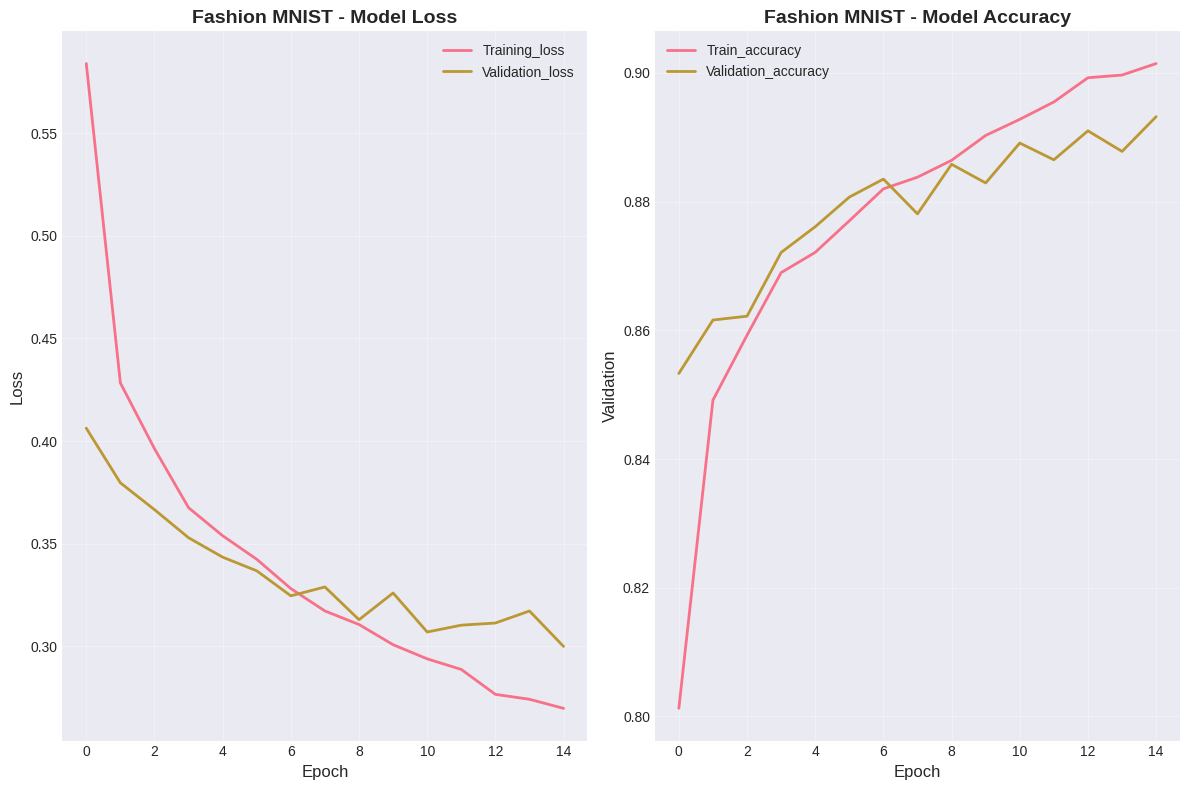

Final Test Accuracy:0.8932 (89.32%)


In [12]:
# Visualize Training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.plot(train_losses_fashion, label='Training_loss', linewidth=2)
ax1.plot(val_losses_fashion, label='Validation_loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Fashion MNIST - Model Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(train_accs_fashion, label='Train_accuracy', linewidth=2)
ax2.plot(val_accs_fashion, label='Validation_accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation', fontsize=12)
ax2.set_title("Fashion MNIST - Model Accuracy", fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Test Accuracy:{val_accs_fashion[-1]:.4f} ({val_accs_fashion[-1]*100:.2f}%)")

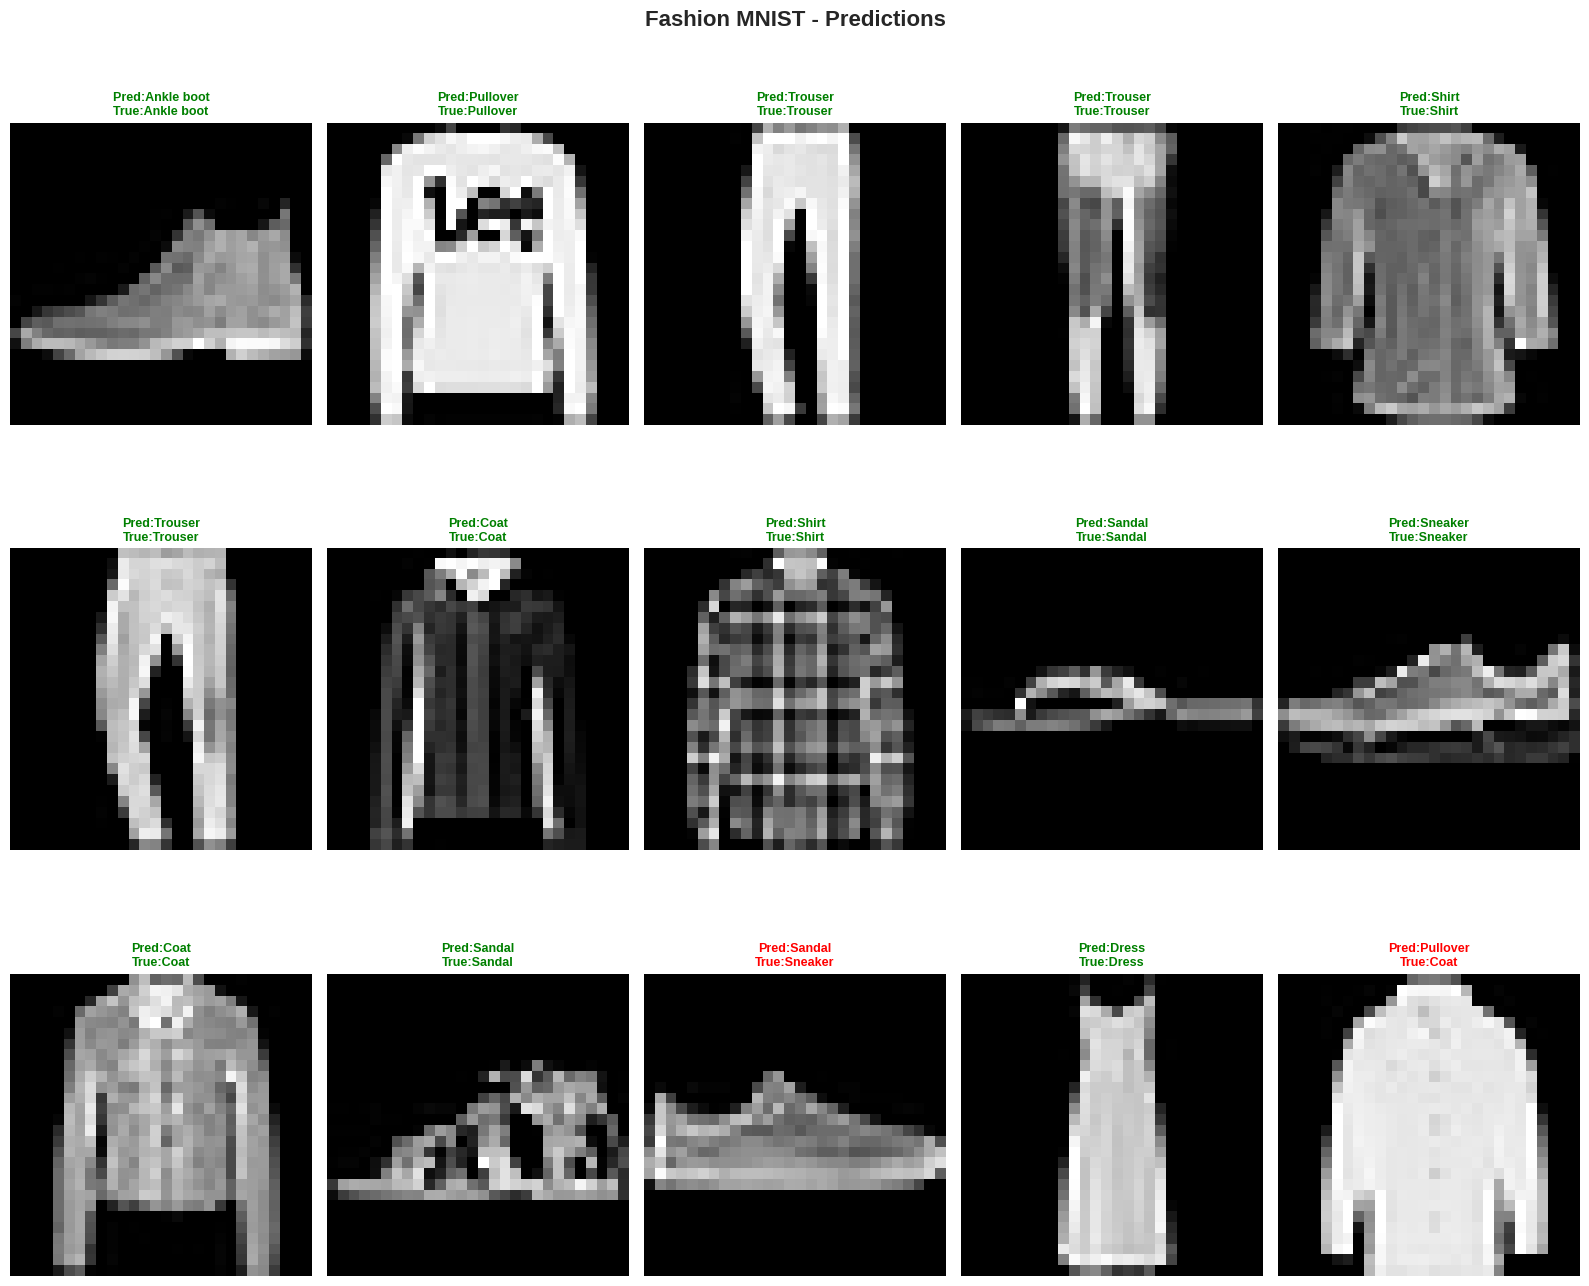

In [13]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#Visualize Predictions
fig, axes = plt.subplots(3, 5, figsize=(16, 14))
plt.suptitle("Fashion MNIST - Predictions", fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
  image, label = test_dataset[i]
  ax.imshow(image.squeeze(), cmap='gray')

  color='green' if all_preds[i] == all_labels[i] else 'red'
  ax.set_title(f"Pred:{class_names[all_preds[i]]}\nTrue:{class_names[all_labels[i]]}",
               color=color, fontsize=9, fontweight='bold')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix, classification_report

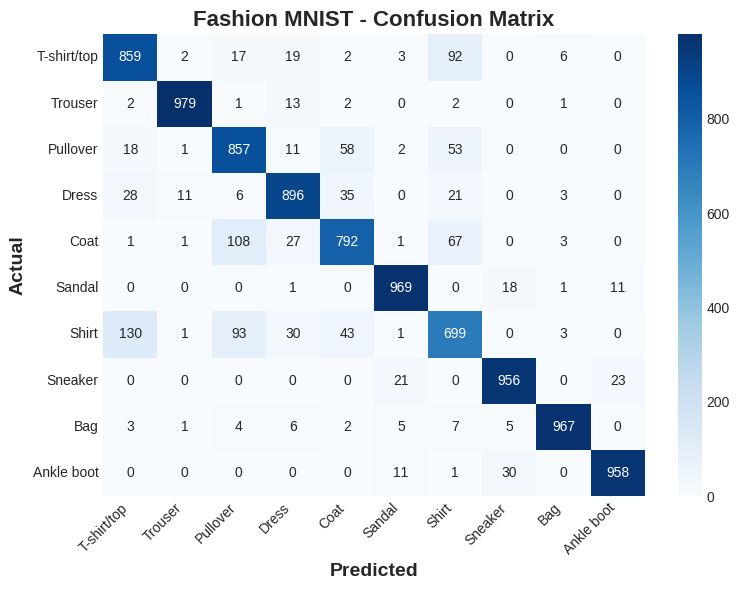

In [15]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title("Fashion MNIST - Confusion Matrix", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [16]:
# Classification Report
print("Classification Report:")
print(f"{classification_report(all_labels, all_preds, target_names=class_names)}")

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.86      0.84      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.79      0.86      0.82      1000
       Dress       0.89      0.90      0.89      1000
        Coat       0.85      0.79      0.82      1000
      Sandal       0.96      0.97      0.96      1000
       Shirt       0.74      0.70      0.72      1000
     Sneaker       0.95      0.96      0.95      1000
         Bag       0.98      0.97      0.97      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



# Save and loading models

Save State dict

In [17]:
torch.save(fashion_model.state_dict(), 'fashion_model.pth')
print("✓ Model state dict saved as 'fashion_model.pth'")

#Save with additional information
checkpoint = {
    'epoch':num_epochs,
    'model_state_dict': fashion_model.state_dict(),
    'optimizer_state_dict': optimizer_fashion.state_dict(),
    'loss': val_losses_fashion[-1]
}

torch.save(checkpoint, 'fashion_checkpoint.pth')
print("✓ Checkpoint saved as 'fashion_checkpoint.pth'")

✓ Model state dict saved as 'fashion_model.pth'
✓ Checkpoint saved as 'fashion_checkpoint.pth'


Load Model

In [18]:
loaded_model = FashionMNISTClassifier().to(device)
loaded_model.load_state_dict(torch.load('fashion_model.pth', map_location = device))
loaded_model.eval()

print("✓ Model loaded successfully!")

# Verify it works
val_loss, val_acc = validate_multiclass(
    loaded_model, test_loader, criterion_fashion, device
)

print(f"Loaded model accuracy:{val_acc:.4f}")

✓ Model loaded successfully!
Loaded model accuracy:0.8932


Load Checkpoint

In [19]:
checkpoint_loaded = torch.load('fashion_checkpoint.pth', map_location=device)

new_model = FashionMNISTClassifier().to(device)
new_optimizer = optim.Adam(new_model.parameters())

new_model.load_state_dict(checkpoint_loaded['model_state_dict'])
new_optimizer.load_state_dict(checkpoint_loaded['optimizer_state_dict'])
epoch = checkpoint_loaded['epoch']
loss = checkpoint_loaded['loss']

print(f"Checkpoint loaded from epoch {epoch}")
print(f"Previous Loss:{loss:.4f}")
print("n✓ You can continue training from this point")

Checkpoint loaded from epoch 15
Previous Loss:0.2999
n✓ You can continue training from this point
